# Hidden Markov Models for Regime Detection using R

[Link to this article.](https://www.quantstart.com/articles/hidden-markov-models-for-regime-detection-using-r/)



In the [previous article](https://www.quantstart.com/articles/hidden-markov-models-an-introduction) in the series Hidden Markov Models were introduced. They were discussed in the context of the broader class of Markov Models. They were motivated by the need for quantitative traders to have the ability to detect market regimes in order to adjust how their quant strategies are managed.

In particular it was mentioned that *"various regimes lead to adjustments of asset returns via shifts in their means, variances/volatilities, serial correlation and covariances, which impact the effectiveness of time series methods that rely on stationarity"*. This has a significant bearing on how trading strategies are modified throughout the strategy lifecycle.

In this article Hidden Markov Models will be implemented using the R statistical language via the Dependent Mixture Models depmixS4 package. They will be used to analyse when US equities markets are in various regime states. In subsequent articles these regime overlays will be used in a subclassed RiskManager module of QSTrader to adjust trade signal suggestions from various strategies.

Within the article a simulation of streamed market returns across two separate regimes - "bullish" and "bearish" - will be carried out. A Hidden Markov Model will be fitted to the returns stream to identify the probability of being in a particular regime state.

Subsequent to outlining the procedure on simulated data the Hidden Markov Model will be applied to US equities data in order to determine two-state underlying regimes.

*Acknowledgements: This article and code is heavily influenced by the post over at Systematic Investor on Regime Detection[6]. Please take a look at the article and references therein for additional discussion.*


## Market Regimes

Applying Hidden Markov Models to regime detection is tricky since the problem is actually a form of **unsupervised learning**. That is, there is no "ground truth" or labelled data on which to "train" the model. In particular it is not clear how many regime states exist a priori. Are there two, three, four or more "true" hidden market regimes?

Answers to these questions depend heavily on the asset class being modelled, the choice of time frame and the nature of data utilised. For instance, daily returns data in equities markets often exhibits periods of calm lower volatility, even over a number of years, with exceptional periods of high volatility in moments of "panic" or "correction". Is it natural then to consider modelling equity indices with two states? Might there be a third intermediate state representing more vol than usual but not outright panic?

Utilising Hidden Markov Models as overlays to a risk manager that can interfere with strategy-generated orders requires careful research analysis and a solid understanding of the asset class(es) being modelled. In future articles the performance of various trading strategies will be studied under various Hidden Markov Model based risk managers.

## Simulated Data

In this section simulated returns data will be generated from separate Gaussian distributions, each of which represents a "bullish" or "bearish" market regime. The bullish returns draw from a Guassian distribution with positive mean and low variance, while the bearish returns draw from a Gaussian distribution with slight negative mean but higher variance.

Five separate market regime periods will be simulated and "stitched" together in R. The subsequent stream of returns will then be utilised by a Hidden Markov Model in order to infer posterior probabilities of the regime states, given the sequence of observations.

The first task is to install the depmixS4 and quantmod libraries and then import them into R. The random seed will also be fixed in order to allow consistent replication of results:

In [2]:
library('depmixS4')
library('quantmod')
set.seed(1)

Loading required package: nnet

Loading required package: MASS

Loading required package: Rsolnp

Loading required package: nlme

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



At this stage a two-regime market will be simulated. This is achieved by assuming market returns are normally distributed. Separate regimes will be simulated with each containing $N_{k}$ days of returns. Each of the $k$ regimes will be bullish or bearish. The goal of the Hidden Markov Model will be to identify when the regime has switched from bullish to bearish and vice versa.

In this example *k*=5 and $N_{k} \in [50, 150]$. The bull market is distributed as $N(0.1, 0.1)$ while the bear market is distributed as $N(-0.05, 0.2)$. The parameters are set via the following code:

In [3]:
# Create the parameters for the bull and
# bear market returns distributions
Nk_lower <- 50
Nk_upper <- 150
bull_mean <- 0.1
bull_var <- 0.1
bear_mean <- -0.05
bear_var <- 0.2

The $N_{k}$ values are randomly chosen:

In [4]:
# Create the list of durations (in days) for each regime
days <- replicate(5, sample(Nk_lower:Nk_upper, 1))

The returns for each *k*th period are randomly drawn:

In [5]:
# Create the various bull and bear markets returns
market_bull_1 <- rnorm( days[1], bull_mean, bull_var ) 
market_bear_2 <- rnorm( days[2], bear_mean, bear_var ) 
market_bull_3 <- rnorm( days[3], bull_mean, bull_var ) 
market_bear_4 <- rnorm( days[4], bear_mean, bear_var ) 
market_bull_5 <- rnorm( days[5], bull_mean, bull_var )

The R code for creating the true regime states (either 1 for bullish or 2 for bearish) and final list of returns is given by the following:

In [6]:
# Create the list of true regime states and full returns list
true_regimes <- c( rep(1,days[1]), rep(2,days[2]), rep(1,days[3]), rep(2,days[4]), rep(1,days[5]))
returns <- c( market_bull_1, market_bear_2, market_bull_3, market_bear_4, market_bull_5)

Plotting the returns shows the clear changes in mean and variance between the regime switches:

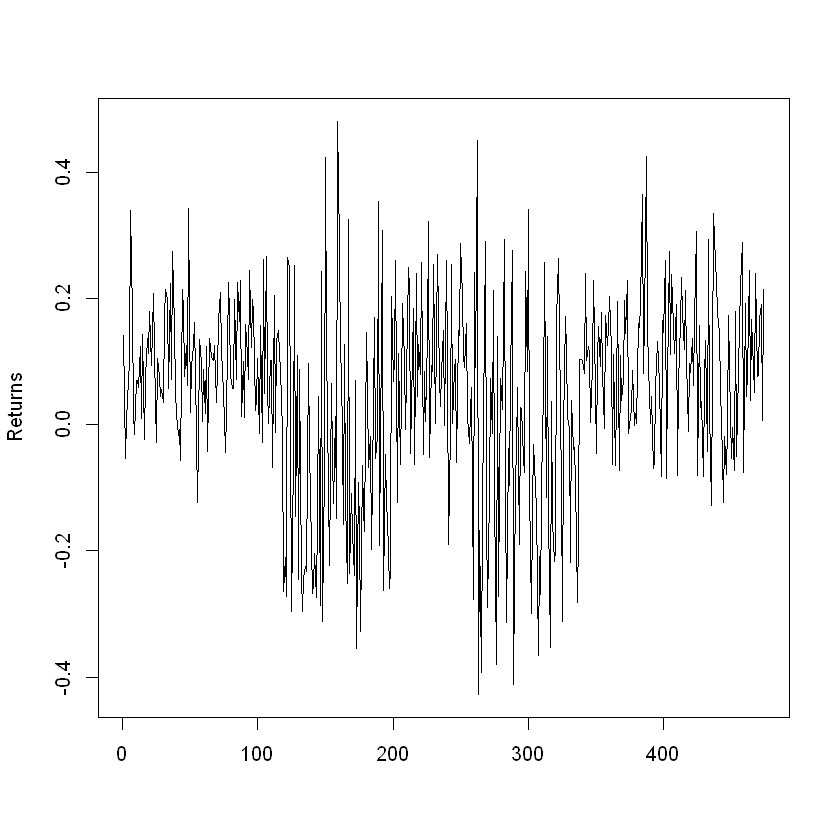

In [7]:
plot(returns, type="l", xlab='', ylab="Returns") 

At this stage the Hidden Markov Model can be specified and fit using the [Expectation Maximisation algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), the details of which are beyond the scope of this article. The family of distributions is specified as gaussian and the number of states is set to two (nstates = 2):

In [8]:
# Create and fit the Hidden Markov Model
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 2, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)

converged at iteration 24 with logLik: 289.6389 


Subsequent to model fitting it is possible to plot the posterior probabilities of being in a particular regime state. post_probs contain the posterior probabilities. These are compared with the underlying true states. Notice that the Hidden Markov Model does a good job of correctly identifying regimes, albeit with some lag:

Warning message in .local(object, ...):
"Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options."


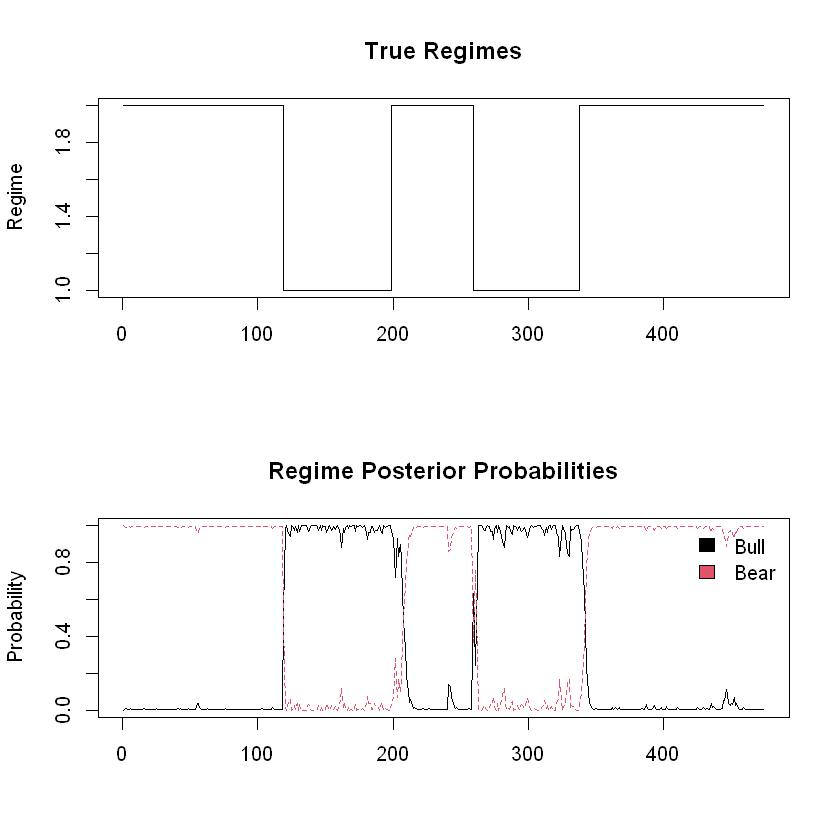

In [9]:
# Output both the true regimes and the 
# posterior probabilities of the regimes
post_probs <- posterior(hmmfit)
layout(1:2)
plot(post_probs$state, type='s', main='True Regimes', xlab='', ylab='Regime')
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='topright', c('Bull','Bear'), fill=1:2, bty='n')

The discussion will now turn towards applying the Hidden Markov Model to real world historical financial data.

## Financial Data

In the above section it was straightforward for the Hidden Markov Model to determine regimes because they had been simulated from pre-specified set of Gaussians. As stated above the problem of Regime Detection is actually an unsupervised learning challenge since the number of states is not known a priori, nor is there any "ground truth" on which to "train" the HMM.

In this section two separate modelling tasks will be carried out. The first will involve fitting the HMM with two regime states to S&P500 returns, while the second will utilise three states. The results between the two models will be compared.

The process for applying the Hidden Markov Model provided by depmixS4 is similar to that carried out for the simulated data. Instead of generating the returns stream from two Gaussian distributions it will simply be downloaded using the quantmod library:

In [10]:
# Obtain S&P500 data from 2004 onwards and
# create the returns stream from this
getSymbols( "^GSPC", from="2004-01-01" )
gspcRets = diff( log( Cl( GSPC ) ) )
returns = as.numeric(gspcRets)

[1] "^GSPC"

The gspcRets time series object can be plotted, showing the volatile periods around 2008 and 2011:

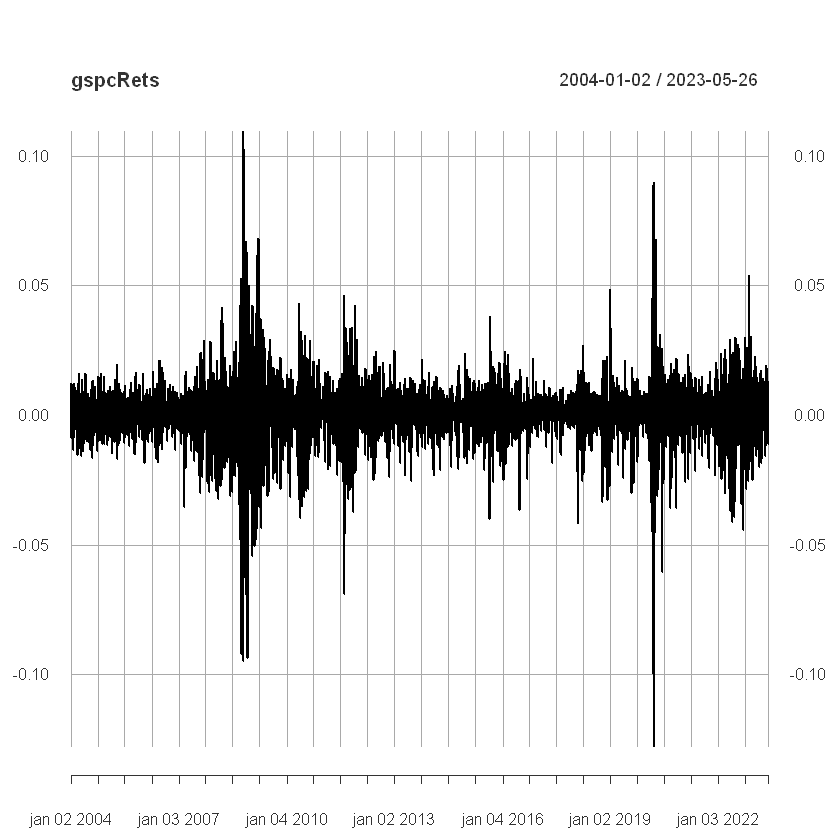

In [11]:
plot(gspcRets)

As before a two-state Hidden Markov Model is fitted using the EM algorithm. The returns and posterior probabilities of each regime are plotted:

converged at iteration 36 with logLik: 15785.5 


Warning message in .local(object, ...):
"Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options."


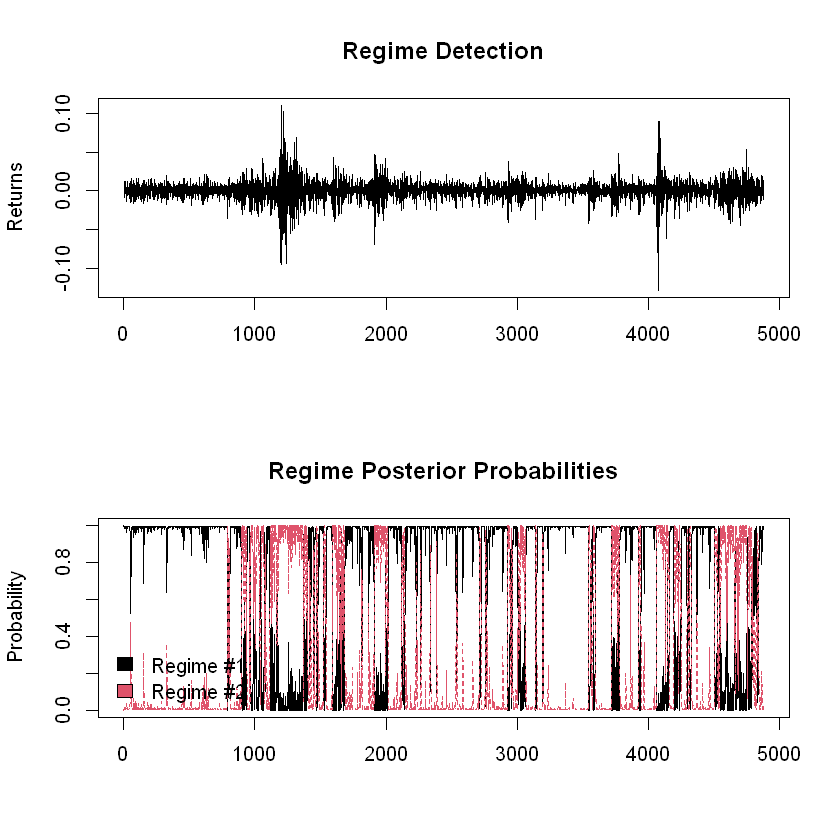

In [12]:
# Fit a Hidden Markov Model with two states 
# to the S&P500 returns stream
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 2, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)
post_probs <- posterior(hmmfit)

# Plot the returns stream and the posterior
# probabilities of the separate regimes
layout(1:2)
plot(returns, type='l', main='Regime Detection', xlab='', ylab='Returns')
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='bottomleft', c('Regime #1','Regime #2'), fill=1:2, bty='n')

Notice that within 2004 and 2007 the markets were calmer and hence the Hidden Markov Model has given high posterior probability to Regime #2 for this period. However between 2007-2009 the markets were incredibly volatile due to the [sub-prime crisis](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%9308). This has the initial effect of rapidly changing the posterior probabilities between the two states but being fairly consistently in Regime #1 during 2008 itself.

The markets became calmer in 2010 but additional volatility occurred in 2011, leading once again for the HMM to give high posterior probability to Regime #1. Subsequent to 2011 the markets became calmer once again and the HMM is consistently giving high probability to Regime #2. In 2015 the markets once again became choppier and this is reflected in the increased switching between regimes for the HMM.

The same process will now be carried out for a three-state HMM. There is little to modify between the two, with the exception of modifying nstates = 3 and adjusting the plotting legend:

converged at iteration 116 with logLik: 16038.29 


Warning message in .local(object, ...):
"Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options."


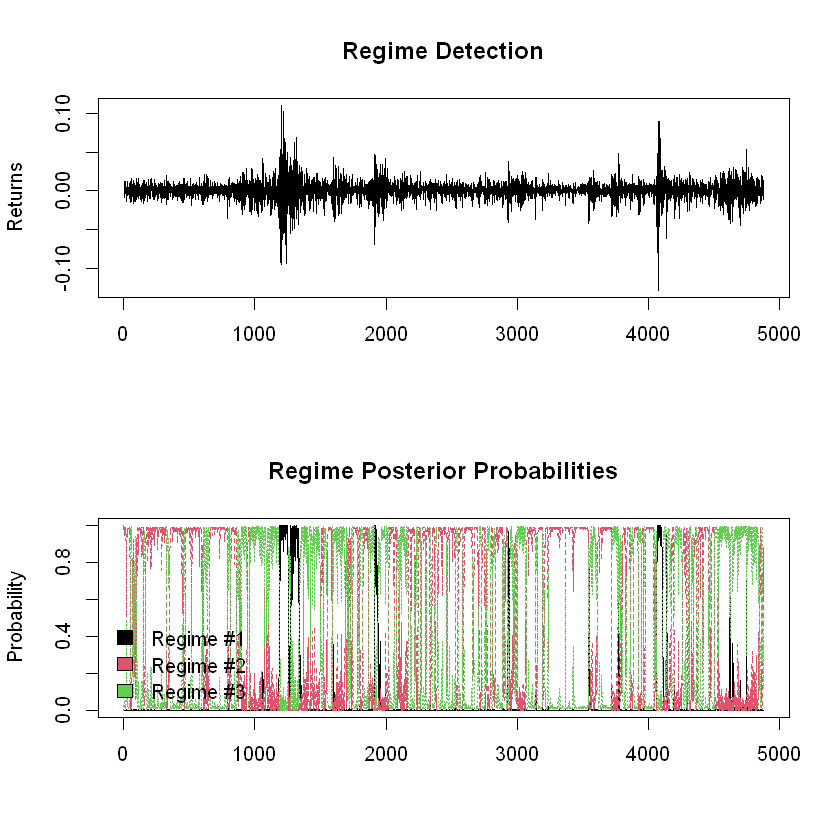

In [13]:
# Fit a Hidden Markov Model with three states 
# to the S&P500 returns stream
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 3, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)
post_probs <- posterior(hmmfit)
 
# Plot the returns stream and the posterior
# probabilities of the separate regimes
layout(1:2)
plot(returns, type='l', main='Regime Detection', xlab='', ylab='Returns')
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='bottomleft', c('Regime #1','Regime #2', 'Regime #3'), fill=1:3, bty='n')

## References

    [1] Kritzman, M., Page, S., Turkington, D. (2012) "Regime Shifts: Implications for Dynamic Strategies", Financial Analysts Journal 68 (3):
    [2] Quantivity (2012) Multi-Asset Market Regimes, https://quantivity.wordpress.com/2012/11/09/multi-asset-market-regimes/
    [3] Slaff, T. (2015) Identifying Changing Market Conditions, https://inovancetech.com/hmm-tutorial-1.html
    [4] Systematic Investor (2012) Regime Detection, https://systematicinvestor.wordpress.com/2012/11/01/regime-detection/
    [5] Systematic Investor (2012) Regime Detection Pitfalls, http://systematicinvestor.wordpress.com/2012/11/15/regime-detection-pitfalls/
    [6] Systematic Investor (2015) Regime Detection Update, http://systematicinvestor.github.io/Regime-Detection-Update
    [7] GekkoQuant (2014) Hidden Markov Models – Model Description Part 1 of 4, http://gekkoquant.com/2014/05/18/hidden-markov-models-model-description-part-1-of-4/
    [8] GekkoQuant (2014) Hidden Markov Models – Forward & Viterbi Algorithm Part 2 of 4, http://gekkoquant.com/2014/05/26/hidden-markov-models-forward-viterbi-algorithm-part-2-of-4/
    [9] GekkoQuant (2014) Hidden Markov Models – Examples In R – Part 3 of 4, http://gekkoquant.com/2014/09/07/hidden-markov-models-examples-in-r-part-3-of-4/
    [10] GekkoQuant (2015) Hidden Markov Models – Trend Following – Part 4 of 4, http://gekkoquant.com/2015/02/01/hidden-markov-models-trend-following-sharpe-ratio-3-1-part-4-of-4/
    [11] Jurafsky, D., Martin, J.H. (2016) Speech and Language Processing (Draft), 3rd Ed., Pearson
    [12] Quantivity (2009) Trade Using Market Regimes?, https://quantivity.wordpress.com/2009/09/20/trade-using-market-regimes/
    [13] Quantivity (2009) Market Regime Dashboard, https://quantivity.wordpress.com/2009/08/23/market-regime-dashboard/
    [14] Wiecki, T. (2013) Inferring latent states using a Gaussian Hidden Markov Model, https://www.quantopian.com/posts/inferring-latent-states-using-a-gaussian-hidden-markov-model
    [15] Davies, G. (2016) Regime changes in the financial markets, http://blogs.ft.com/gavyndavies/2016/07/24/regime-changes-in-the-financial-markets/
    [16] Schreiber, J. (2016) Hidden Markov Models (Pomegranate Tutorial), https://github.com/jmschrei/pomegranate/blob/master/tutorials/Tutorial_3_Hidden_Markov_Models.ipynb


## Full code

In [ ]:
# Import the necessary packages and set 
# random seed for replication consistency
install.packages('depmixS4')
install.packages('quantmod')
library('depmixS4')
library('quantmod')
set.seed(1)

# Create the parameters for the bull and 
# bear market returns distributions
Nk_lower <- 50
Nk_upper <- 150
bull_mean <- 0.1
bull_var <- 0.1
bear_mean <- -0.05
bear_var <- 0.2

# Create the list of durations (in days) for each regime
days <- replicate(5, sample(Nk_lower:Nk_upper, 1))

# Create the various bull and bear markets returns
market_bull_1 <- rnorm( days[1], bull_mean, bull_var ) 
market_bear_2 <- rnorm( days[2], bear_mean, bear_var ) 
market_bull_3 <- rnorm( days[3], bull_mean, bull_var ) 
market_bear_4 <- rnorm( days[4], bear_mean, bear_var ) 
market_bull_5 <- rnorm( days[5], bull_mean, bull_var ) 

# Create the list of true regime states and full returns list
true_regimes <- c( rep(1,days[1]), rep(2,days[2]), rep(1,days[3]), rep(2,days[4]), rep(1,days[5]))
returns <- c( market_bull_1, market_bear_2, market_bull_3, market_bear_4, market_bull_5)

# Create and fit the Hidden Markov Model
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 2, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)
post_probs <- posterior(hmmfit)

# Output both the true regimes and the 
# posterior probabilities of the regimes
layout(1:2)
plot(post_probs$state, type='s', main='True Regimes', xlab='', ylab='Regime')
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='topright', c('Bull','Bear'), fill=1:2, bty='n')

# Obtain S&P500 data from 2004 onwards and
# create the returns stream from this
getSymbols( "^GSPC", from="2004-01-01" )
gspcRets = diff( log( Cl( GSPC ) ) )
returns = as.numeric(gspcRets)

# Fit a Hidden Markov Model with two states 
# to the S&P500 returns stream
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 2, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)
post_probs <- posterior(hmmfit)

# Plot the returns stream and the posterior
# probabilities of the separate regimes
layout(1:2)
plot(returns, type='l', main='Regime Detection', xlab='', ylab='Returns')
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='topright', c('Regime #1','Regime #2'), fill=1:2, bty='n')

# Fit a Hidden Markov Model with three states 
# to the S&P500 returns stream
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 3, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)
post_probs <- posterior(hmmfit)

# Plot the returns stream and the posterior
# probabilities of the separate regimes
layout(1:2)
plot(returns, type='l', main='Regime Detection', xlab='', ylab='Returns')
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='bottomleft', c('Regime #1','Regime #2', 'Regime #3'), fill=1:3, bty='n')